
# FIAP — Fase 5 — Entrega 1 (Machine Learning)
**Projeto: FarmTech Solutions — Previsão de Rendimento de Safra e Tendências de Produtividade**

> **Como usar**  
> 1. Coloque o arquivo `crop_yield.csv` na **mesma pasta** deste notebook.  
> 2. Execute as células em ordem (Menu: Kernel → Restart & Run All).  


In [1]:

# === Imports principais ===
import os
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

import joblib

print("Versões:")
print("Python:", sys.version.split()[0])
import sklearn, matplotlib
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)


Versões:
Python: 3.13.2
scikit-learn: 1.7.1
pandas: 2.3.0
numpy: 2.3.0
matplotlib: 3.10.5


## 1) Carregamento da base

In [2]:

# Caminho do dataset
DATA_PATH = Path("crop_yield.csv")

assert DATA_PATH.exists(), "Arquivo 'crop_yield.csv' não encontrado. Coloque-o na mesma pasta do notebook."

df = pd.read_csv(DATA_PATH)
print("Formato:", df.shape)
display(df.head(10))
display(df.sample(min(10, len(df))))
df.info()


Formato: (156, 6)


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800
5,"Cocoa, beans",2339.30,17.70,84.54,25.76,8850
6,"Cocoa, beans",2326.09,18.09,84.63,26.11,9003
7,"Cocoa, beans",2718.08,18.30,85.43,26.12,9880
8,"Cocoa, beans",2061.61,17.80,84.36,25.88,9201
9,"Cocoa, beans",1934.62,17.94,83.43,26.21,8300


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
21,"Cocoa, beans",2302.99,18.22,84.48,26.25,9801
79,"Rice, paddy",1938.42,17.54,82.11,26.11,27619
155,"Rubber, natural",2109.34,18.51,83.52,26.72,5903
91,"Rice, paddy",2504.70,18.19,85.45,26.02,30614
132,"Rubber, natural",2414.79,18.18,85.76,25.93,6562
38,"Cocoa, beans",2109.34,18.51,83.52,26.72,8848
63,Oil palm fruit,2363.63,18.35,84.92,26.28,184629
25,"Cocoa, beans",2892.78,18.49,86.09,26.18,10062
104,"Rice, paddy",2729.53,18.41,86.03,26.11,35277
36,"Cocoa, beans",2967.41,18.67,85.48,26.46,7314


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


## 2) Limpeza inicial e checagens

In [3]:

# Normaliza nomes de colunas (tira espaços, acentos comuns, deixa snake_case)
def normalize_colname(c):
    return (
        c.strip()
         .replace("ã","a").replace("á","a").replace("à","a").replace("â","a")
         .replace("é","e").replace("ê","e")
         .replace("í","i")
         .replace("ó","o").replace("ô","o")
         .replace("ú","u")
         .replace("ç","c")
         .replace("%","pct")
         .replace("º","o")
         .replace("°","o")
         .replace("/","_")
         .replace("-","_")
         .replace("(","").replace(")","")
         .replace(".","")
         .replace(":","")
         .replace("  "," ")
         .lower()
         .replace(" ","_")
    )

df.columns = [normalize_colname(c) for c in df.columns]

print("Colunas:", list(df.columns))

# Tentativa de mapear colunas esperadas
expected = {
    "cultura": ["cultura", "crop", "culture"],
    "precipitacao_mm_dia_1": ["precipitacao_mm_dia_1","precipitacao","chuva_mm","precipitation"],
    "umidade_especifica_a_2_metros_g_kg": ["umidade_especifica_a_2_metros_g_kg","umidade_especifica","specific_humidity"],
    "umidade_relativa_a_2_metros_pct": ["umidade_relativa_a_2_metros_pct","umidade_relativa","relative_humidity"],
    "temperatura_a_2_metros_oc": ["temperature_at_2_meters_c"],
     "rendimento": ["rendimento","yield","y_t_ha","ton_ha"]
}

# Encontra melhor correspondência disponível
resolved = {}
for key, options in expected.items():
    found = None
    for col in df.columns:
        if col in options:
            found = col
            break
    if found is None:
        # tenta por contenção
        for col in df.columns:
            for opt in options:
                if opt in col:
                    found = col
                    break
            if found: break
    resolved[key] = found

print("Mapeamento de colunas (esperado -> encontrado):")
for k,v in resolved.items():
    print(f"  {k:40s} -> {v}")

missing = [k for k,v in resolved.items() if v is None]
assert len(missing)==0, f"Não foi possível resolver automaticamente estas colunas: {missing}. Ajuste manualmente o mapeamento acima."

# Renomeia para nomes padronizados
df = df.rename(columns={resolved[k]: k for k in resolved})

# Remove duplicatas óbvias
antes = len(df)
df = df.drop_duplicates()
print(f"Duplicatas removidas: {antes - len(df)}")

# Trata espaços e strings na coluna de cultura
df["cultura"] = df["cultura"].astype(str).str.strip()

# Checa nulos
nulos = df.isna().sum().sort_values(ascending=False)
print("Nulos por coluna:")
display(nulos.to_frame("nulos"))


Colunas: ['crop', 'precipitation_mm_day_1', 'specific_humidity_at_2_meters_g_kg', 'relative_humidity_at_2_meters_pct', 'temperature_at_2_meters_c', 'yield']
Mapeamento de colunas (esperado -> encontrado):
  cultura                                  -> crop
  precipitacao_mm_dia_1                    -> precipitation_mm_day_1
  umidade_especifica_a_2_metros_g_kg       -> specific_humidity_at_2_meters_g_kg
  umidade_relativa_a_2_metros_pct          -> relative_humidity_at_2_meters_pct
  temperatura_a_2_metros_oc                -> temperature_at_2_meters_c
  rendimento                               -> yield
Duplicatas removidas: 0
Nulos por coluna:


,nulos
cultura,0
precipitacao_mm_dia_1,0
umidade_especifica_a_2_metros_g_kg,0
umidade_relativa_a_2_metros_pct,0
temperatura_a_2_metros_oc,0
rendimento,0


## 3) Análise Exploratória (EDA)

,cultura,precipitacao_mm_dia_1,umidade_especifica_a_2_metros_g_kg,umidade_relativa_a_2_metros_pct,temperatura_a_2_metros_oc,rendimento
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000


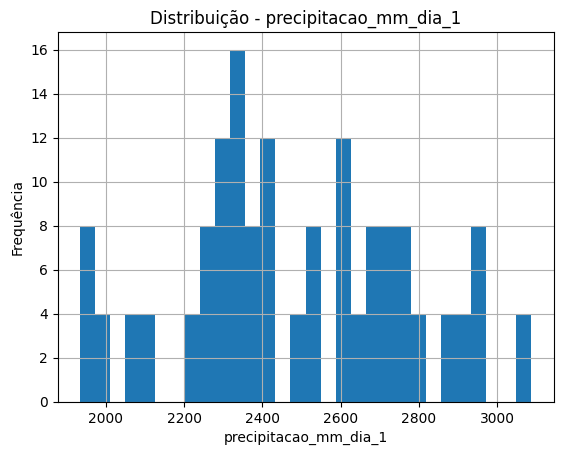

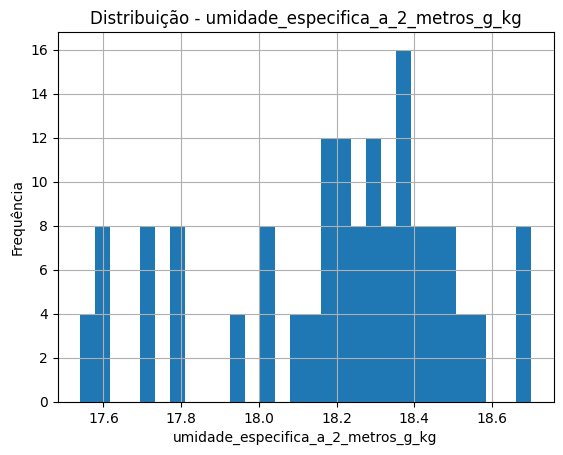

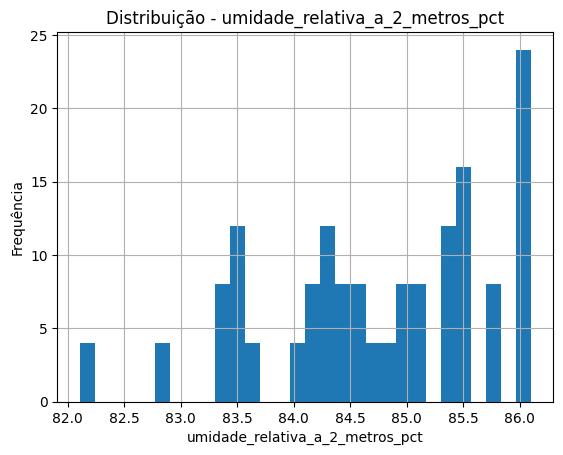

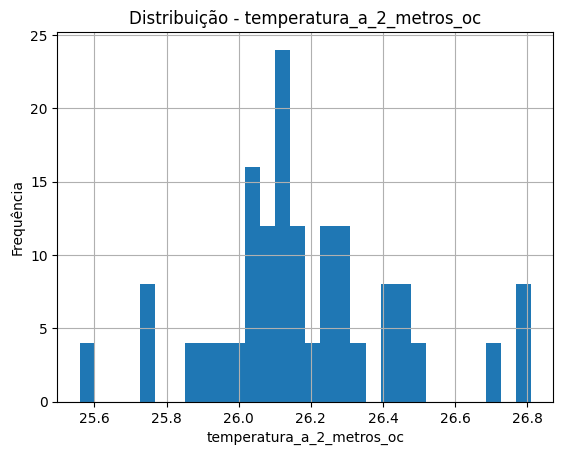

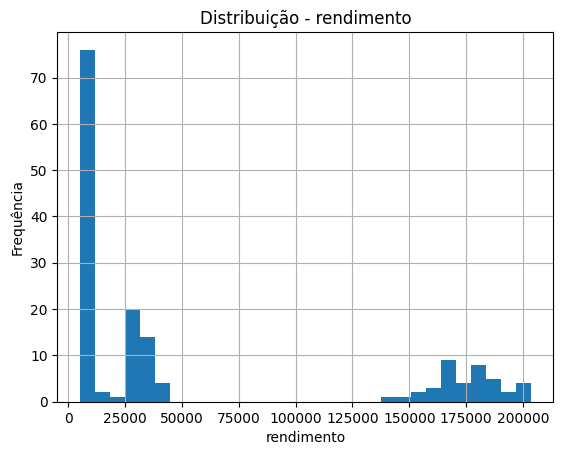

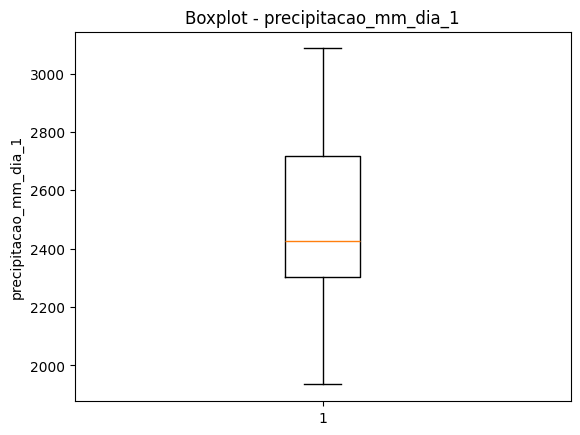

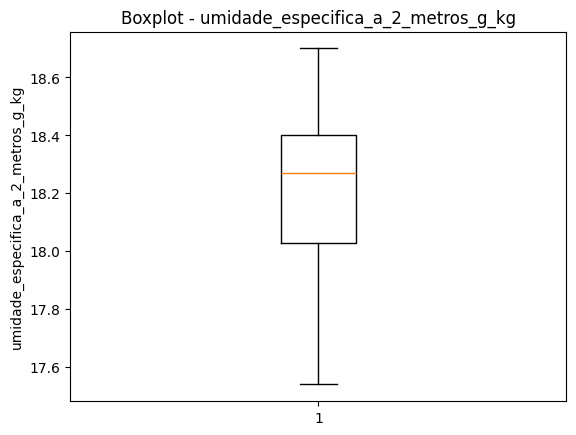

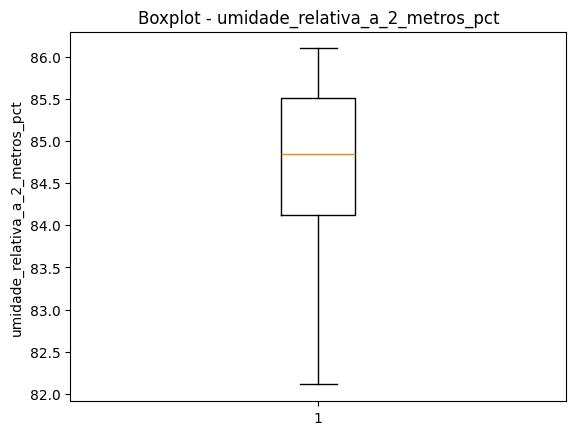

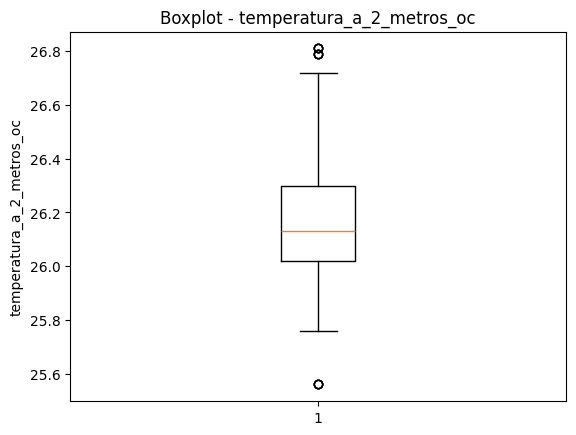

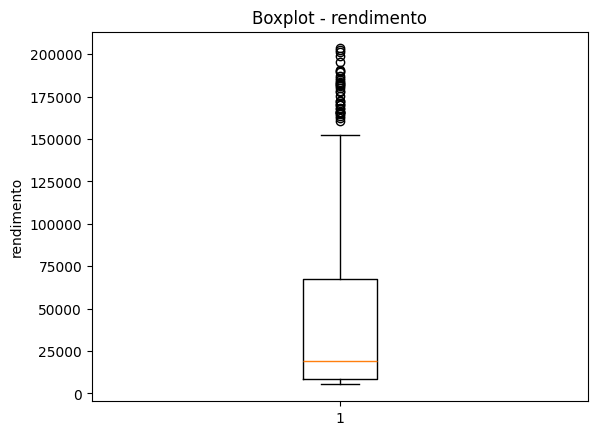

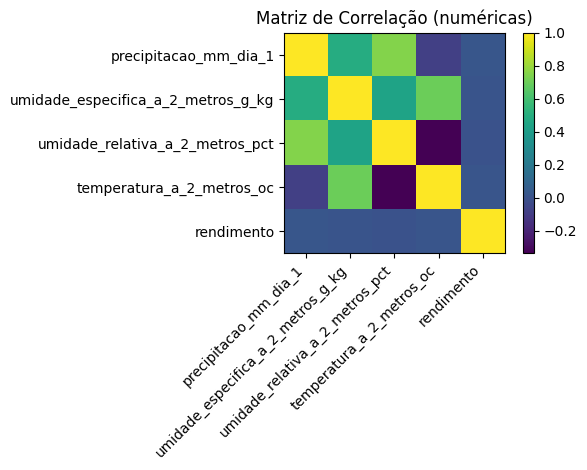

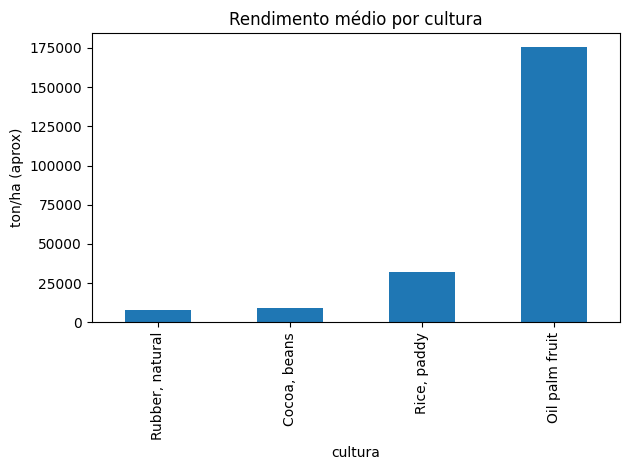

In [4]:

# Estatísticas descritivas
display(df.describe(include='all'))

# Distribuições (histogramas) para numéricas
num_cols = ["precipitacao_mm_dia_1","umidade_especifica_a_2_metros_g_kg",
            "umidade_relativa_a_2_metros_pct","temperatura_a_2_metros_oc","rendimento"]

for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribuição - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()

# Boxplots para detectar valores extremos por variável
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot - {col}")
    plt.ylabel(col)
    plt.show()

# Correlação (numéricas)
corr = df[num_cols].corr()
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Matriz de Correlação (numéricas)")
plt.tight_layout()
plt.show()

# Rendimento médio por cultura (se fizer sentido no dataset)
plt.figure()
df.groupby("cultura")["rendimento"].mean().sort_values().plot(kind="bar")
plt.title("Rendimento médio por cultura")
plt.ylabel("ton/ha (aprox)")
plt.tight_layout()
plt.show()


## 4) Outliers (cenários discrepantes)

In [5]:

# Método IQR simples para flag de outliers por coluna numérica
def iqr_outlier_flags(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor*iqr
    upper = q3 + factor*iqr
    return (series < lower) | (series > upper)

outlier_flags = pd.DataFrame(index=df.index)
for col in ["precipitacao_mm_dia_1","umidade_especifica_a_2_metros_g_kg",
            "umidade_relativa_a_2_metros_pct","temperatura_a_2_metros_oc","rendimento"]:
    outlier_flags[col+"_outlier"] = iqr_outlier_flags(df[col])

df["qtd_outlier_flags"] = outlier_flags.sum(axis=1)
print("Registros com >=2 flags de outlier (IQR):", (df["qtd_outlier_flags"]>=2).sum())

# Isolation Forest para referência (apenas numéricas)
X_iso = df[["precipitacao_mm_dia_1","umidade_especifica_a_2_metros_g_kg",
            "umidade_relativa_a_2_metros_pct","temperatura_a_2_metros_oc","rendimento"]].copy()

iso = IsolationForest(random_state=42, contamination="auto")
iso_labels = iso.fit_predict(X_iso)  # -1 = outlier, 1 = normal
df["iso_outlier"] = (iso_labels == -1)
print("Outliers (IsolationForest):", df["iso_outlier"].sum())

display(df[df["iso_outlier"]].head(20))


Registros com >=2 flags de outlier (IQR): 2
Outliers (IsolationForest): 63


,cultura,precipitacao_mm_dia_1,umidade_especifica_a_2_metros_g_kg,umidade_relativa_a_2_metros_pct,temperatura_a_2_metros_oc,rendimento,qtd_outlier_flags,iso_outlier
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,0,True
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,0,True
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,1,True
9,"Cocoa, beans",1934.62,17.94,83.43,26.21,8300,0,True
17,"Cocoa, beans",2362.80,18.70,84.03,26.79,7663,1,True
27,"Cocoa, beans",3085.79,18.34,86.10,26.03,13056,0,True
35,"Cocoa, beans",2410.13,18.58,83.45,26.81,11487,1,True
36,"Cocoa, beans",2967.41,18.67,85.48,26.46,7314,0,True
38,"Cocoa, beans",2109.34,18.51,83.52,26.72,8848,0,True
39,Oil palm fruit,2248.92,17.72,83.40,26.01,169783,1,True


## 5) Tendências de produtividade (Clusterização)

Silhouette por k: {2: 0.3924128249740136, 3: 0.43534616694387185, 4: 0.43967757757993314, 5: 0.4249247180780145, 6: 0.44571743189477164}
k escolhido: 6


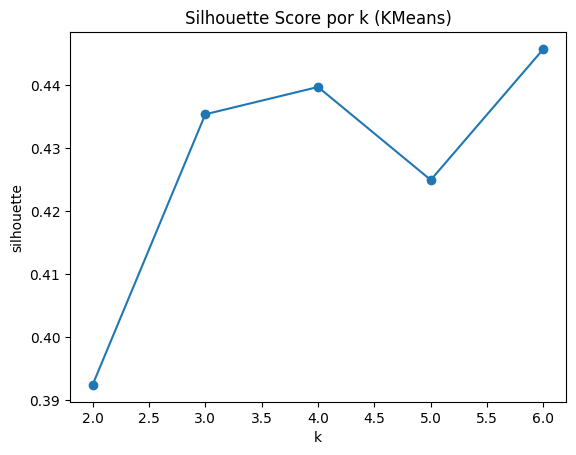

,samples,rendimento_medio,precipitacao_media,umid_espec_media,umid_rel_media,temp_media
cluster,,,,,,
4,20,60503.850000,2480.170000,18.352000,84.168000,26.434000
3,52,57655.711538,2814.984615,18.380000,85.722308,26.143846
5,16,55710.625000,2334.495000,17.680000,84.522500,25.740000
2,16,55490.625000,2105.875000,17.752500,82.932500,26.142500
0,12,55159.833333,2294.090000,18.596667,83.666667,26.773333
1,40,52764.275000,2333.406000,18.170000,84.872000,26.127000


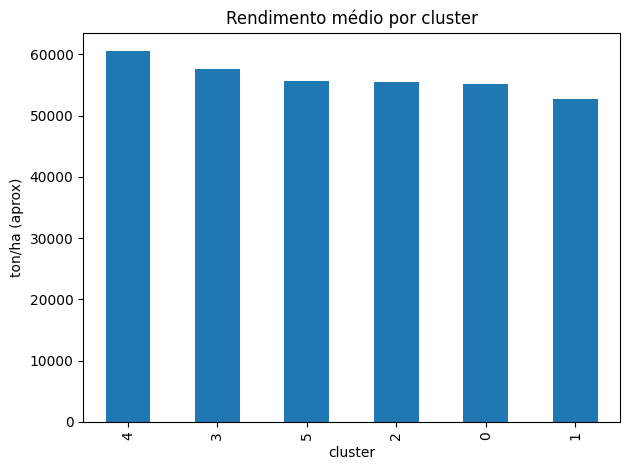

In [6]:

# Para identificar tendências, clusterizamos com base nas variáveis climáticas
cluster_features = ["precipitacao_mm_dia_1","umidade_especifica_a_2_metros_g_kg",
                    "umidade_relativa_a_2_metros_pct","temperatura_a_2_metros_oc"]

X_cluster = df[cluster_features].copy()

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Escolha de k por silhueta (2 a 6)
k_range = range(2, 7)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

best_k = k_range[np.argmax(scores)]
print("Silhouette por k:", dict(zip(k_range, scores)))
print("k escolhido:", best_k)

plt.figure()
plt.plot(list(k_range), scores, marker="o")
plt.title("Silhouette Score por k (KMeans)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.show()

# Fit final
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = km.fit_predict(X_scaled)

# Produtividade média por cluster
cluster_summary = df.groupby("cluster").agg(
    samples=("cluster","count"),
    rendimento_medio=("rendimento","mean"),
    precipitacao_media=("precipitacao_mm_dia_1","mean"),
    umid_espec_media=("umidade_especifica_a_2_metros_g_kg","mean"),
    umid_rel_media=("umidade_relativa_a_2_metros_pct","mean"),
    temp_media=("temperatura_a_2_metros_oc","mean")
).sort_values("rendimento_medio", ascending=False)

display(cluster_summary)

plt.figure()
cluster_summary["rendimento_medio"].plot(kind="bar")
plt.title("Rendimento médio por cluster")
plt.ylabel("ton/ha (aprox)")
plt.tight_layout()
plt.show()


## 6) Preparação dos dados para Modelagem (Supervisionado)

In [7]:

target = "rendimento"
features = ["cultura","precipitacao_mm_dia_1","umidade_especifica_a_2_metros_g_kg",
            "umidade_relativa_a_2_metros_pct","temperatura_a_2_metros_oc"]

X = df[features].copy()
y = df[target].copy()

cat_cols = ["cultura"]
num_cols = [c for c in features if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (124, 5)  Test: (32, 5)


## 7) Modelagem: 5 algoritmos de Regressão + Validação

,Modelo,CV R2 (média),CV R2 (std),Teste MAE,Teste RMSE,Teste R2
3,RandomForest,0.987722,0.004489,2540.288924,4282.965824,0.995271
0,LinearRegression,0.985240,0.004413,3132.796384,4394.165819,0.995022
2,Lasso,0.985379,0.004350,3187.152848,4425.630711,0.994951
1,Ridge,0.985932,0.004104,3295.540958,4490.914064,0.994801
4,GradientBoosting,0.988699,0.003895,3461.376794,6495.300577,0.989124


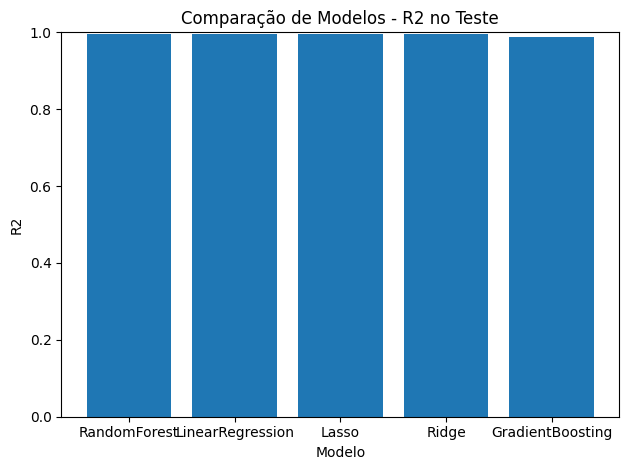

Melhor modelo: RandomForest  | R2 teste: 0.9953


In [8]:

def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    # Cross-validation R2 para estabilidade
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="r2")

    # Fit final e métricas no teste
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    return {
        "model": name,
        "cv_r2_mean": np.mean(cv_scores),
        "cv_r2_std": np.std(cv_scores),
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2": r2,
        "fitted": pipeline
    }

models = []

# 1) Regressão Linear
pipe_lr = Pipeline([("prep", preprocess),
                    ("est", LinearRegression())])
models.append(("LinearRegression", pipe_lr, {}))

# 2) Ridge
pipe_ridge = Pipeline([("prep", preprocess),
                       ("est", Ridge())])
grid_ridge = {"est__alpha":[0.1, 1.0, 10.0]}
models.append(("Ridge", pipe_ridge, grid_ridge))

# 3) Lasso
pipe_lasso = Pipeline([("prep", preprocess),
                       ("est", Lasso(max_iter=10000))])
grid_lasso = {"est__alpha":[0.001, 0.01, 0.1, 1.0]}
models.append(("Lasso", pipe_lasso, grid_lasso))

# 4) RandomForest
pipe_rf = Pipeline([("prep", preprocess),
                    ("est", RandomForestRegressor(random_state=42))])
grid_rf = {"est__n_estimators":[100, 300],
           "est__max_depth":[None, 5, 10]}
models.append(("RandomForest", pipe_rf, grid_rf))

# 5) GradientBoosting
pipe_gb = Pipeline([("prep", preprocess),
                    ("est", GradientBoostingRegressor(random_state=42))])
grid_gb = {"est__n_estimators":[100, 300],
           "est__learning_rate":[0.05, 0.1],
           "est__max_depth":[2,3]}
models.append(("GradientBoosting", pipe_gb, grid_gb))

results = []
best_fit = None
best_name = None
best_score = -np.inf

for name, pipe, grid in models:
    if grid:
        # Pequena busca de hiperparâmetros
        gs = GridSearchCV(pipe, grid, scoring="r2", cv=3, n_jobs=-1)
        gs.fit(X_train, y_train)
        best_pipe = gs.best_estimator_
    else:
        best_pipe = pipe

    res = evaluate_model(name, best_pipe, X_train, y_train, X_test, y_test)
    results.append(res)

    if res["test_r2"] > best_score:
        best_score = res["test_r2"]
        best_fit = res["fitted"]
        best_name = name

# Tabela comparativa
perf = pd.DataFrame([{
    "Modelo": r["model"],
    "CV R2 (média)": r["cv_r2_mean"],
    "CV R2 (std)": r["cv_r2_std"],
    "Teste MAE": r["test_mae"],
    "Teste RMSE": r["test_rmse"],
    "Teste R2": r["test_r2"]
} for r in results]).sort_values("Teste R2", ascending=False)

display(perf)

plt.figure()
plt.bar(perf["Modelo"], perf["Teste R2"])
plt.title("Comparação de Modelos - R2 no Teste")
plt.xlabel("Modelo")
plt.ylabel("R2")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("Melhor modelo:", best_name, " | R2 teste:", round(best_score, 4))


## 8) Importância de atributos (permuta)

,feature,importance_mean
0,cultura,2.020129
1,precipitacao_mm_dia_1,0.000986
2,umidade_especifica_a_2_metros_g_kg,0.000746
3,umidade_relativa_a_2_metros_pct,0.000394
4,temperatura_a_2_metros_oc,-0.000338


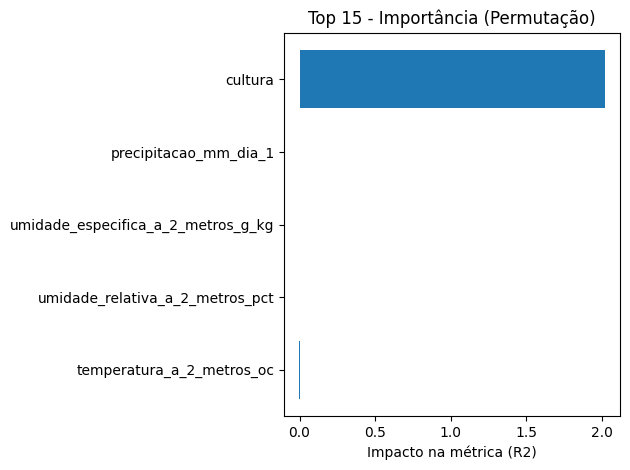

In [9]:

# Tenta extrair nomes após o ColumnTransformer (OneHot + Num)
prep = best_fit.named_steps["prep"]
cat_cols = prep.transformers_[0][2]
num_cols = prep.transformers_[1][2]

ohe = prep.named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = cat_names + list(num_cols)

# Importância por permutação no conjunto de teste
r = permutation_importance(best_fit, X_test, y_test, n_repeats=10, random_state=42, scoring="r2")
imp = pd.DataFrame({"feature": X_test.columns, "importance_mean": r.importances_mean})
imp = imp.sort_values("importance_mean", ascending=False)

display(imp.head(15))

plt.figure()
plt.barh(imp["feature"].head(15)[::-1], imp["importance_mean"].head(15)[::-1])
plt.title("Top 15 - Importância (Permutação)")
plt.xlabel("Impacto na métrica (R2)")
plt.tight_layout()
plt.show()


## 9) Artefatos: salvar melhor modelo e previsões

Nesta seção, salvamos o modelo treinado e as previsões para entrega ou uso futuro.

In [10]:
import os
import joblib
import pandas as pd

# === 1) Criar pasta para artefatos ===
pasta_artefatos = 'artefatos'
if not os.path.exists(pasta_artefatos):
    os.makedirs(pasta_artefatos)

# === 2) Salvar o melhor modelo ===
caminho_modelo = os.path.join(pasta_artefatos, 'melhor_modelo.pkl')
joblib.dump(best_fit, caminho_modelo)
print(f'Modelo salvo em: {caminho_modelo}')

# === 3) Salvar previsões do conjunto de teste ===
previsoes = best_fit.predict(X_test)
df_previsoes = pd.DataFrame({
    'y_real': y_test,
    'y_pred': previsoes
})
caminho_previsoes = os.path.join(pasta_artefatos, 'previsoes.csv')
df_previsoes.to_csv(caminho_previsoes, index=False)
print(f'Previsões salvas em: {caminho_previsoes}')

Modelo salvo em: artefatos\melhor_modelo.pkl
Previsões salvas em: artefatos\previsoes.csv
